In [3]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Classifying by skin cancer/disease type
Six classifier

### Create Datasets (split into train, test, val)

In [44]:
df = pd.read_csv("../data/metadata.csv")

In [45]:
df.shape

(300, 27)

In [46]:
new_df = df[['img_id', 'diagnostic']]

In [47]:
# edit file path name
new_df['img_id'] = "../DATA/images/" + new_df['img_id'].astype(str)

C:\Users\surfd\AppData\Local\Temp\ipykernel_24180\421877499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['img_id'] = "../DATA/images/" + new_df['img_id'].astype(str)


In [48]:
# edit skin disease names into numeric classes
mapping = {'BCC':0, 'MEL':1, 'SCC':2 , 'ACK':3, 'NEV':4, 'SEK':5}
new_df['class'] = new_df['diagnostic'].map(mapping)
new_df = new_df.drop(['diagnostic'], axis=1)
#new_df = new_df[['img_id', 'class', 'diagnostic']]

C:\Users\surfd\AppData\Local\Temp\ipykernel_24180\4075627458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['class'] = new_df['diagnostic'].map(mapping)


In [49]:
# split into training (60%), testing (20%), and validation data (20%)
train_df, temp = train_test_split(new_df, test_size=0.4, random_state=42)  # 60% train
test_df, val_df = train_test_split(temp, test_size=0.5, random_state=42)  # Split remaining 40% equally

train_df.to_csv("../data/train6.csv", index=False)
test_df.to_csv("../data/test6.csv", index=False)
val_df.to_csv("../data/val6.csv", index=False)

### Set up to use Efficient Net model

In [50]:
# setup custom dataset

class SkinCancerDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

In [51]:
# augment data / resize

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [52]:
# load data with dataloader

train_dataset = SkinCancerDataset(csv_file='../data/train6.csv', transform=train_transforms)
val_dataset = SkinCancerDataset(csv_file='../data/val6.csv', transform=val_transforms)
test_dataset = SkinCancerDataset(csv_file='../data/test6.csv', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [53]:
# load EfficientNet and modify the classifier layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(pretrained=True)
num_classes = len(train_dataset.data['class'].unique())
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

c:\Users\surfd\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\surfd\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Test base model

In [54]:
def evaluate_model(model, dloader, ft_check):
    model.eval()
    dpreds, dlabels = [], []
    dprobs = []

    with torch.no_grad():
        for images, labels in dloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get the predicted class for each image (for accuracy and f1)
            preds = outputs.argmax(dim=1)
            # Get predicted probabilities for AUC (softmax output)
            probs = F.softmax(outputs, dim=1)

            # Store predictions and true labels
            dpreds.extend(preds.cpu().numpy())
            dlabels.extend(labels.cpu().numpy())

            # Store probabilities (for AUC)
            dprobs.extend(probs.cpu().numpy())

    for idx in dpreds:
        label = list(mapping.keys())[list(mapping.values()).index(idx)]
        prob = torch.softmax(outputs, dim=1)[0, idx].item()
        print('{:<75} ({:.2f}%)'.format(label, prob*100))

    accuracy = accuracy_score(dlabels, dpreds)
    f1 = f1_score(dlabels, dpreds, average='macro')
    auc = roc_auc_score(dlabels, dprobs, average='macro', multi_class='ovr')  # need to use probabilities instead of predictions for multiclass auc

    print(f'Accuracy: {accuracy}')
    print(f'F1 Score: {f1}')
    print(f'AUC: {auc}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(dlabels, dpreds)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=mapping.keys(), yticklabels=mapping.keys())
    plt.xlabel("Predicted Labels")

    # Using this code for evaluating both the base / pretrained model and the fine-tuned model
    plt.ylabel("True Labels")
    if(ft_check):
        plt.title("Fine-tuned Efficient Net Model Confusion Matrix")
    else:
        plt.title("Pre-trained Efficient Net Model Confusion Matrix")
    plt.show()

NEV                                                                         (12.92%)
BCC                                                                         (18.56%)
BCC                                                                         (18.56%)
NEV                                                                         (12.92%)
NEV                                                                         (12.92%)
MEL                                                                         (14.12%)
BCC                                                                         (18.56%)
NEV                                                                         (12.92%)
NEV                                                                         (12.92%)
SEK                                                                         (13.91%)
BCC                                                                         (18.56%)
SEK                                                              

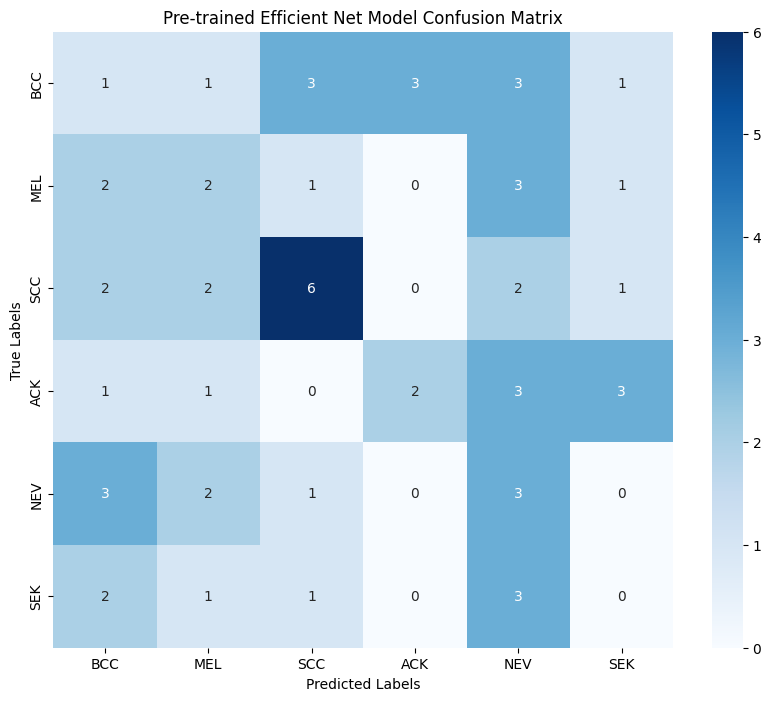

In [55]:
evaluate_model(model, val_loader, False)

### Fine-tuning

In [56]:
# freeze earlier layers / only fine tune the bottom layer
for param in model.features.parameters():
    param.requires_grad = False

In [57]:
# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [58]:
# Training and Validation Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            print(images)
            print(labels)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, '
              f'Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Save the best model based on validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

In [59]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

tensor([[[[-2.1179, -2.1179, -2.1179,  ...,  0.8618,  0.7419, -2.1179],
          [ 1.1358,  0.9988,  0.8618,  ...,  0.7933,  0.7762, -2.1179],
          [ 0.9817,  0.9303,  0.8789,  ...,  0.7762,  0.6906, -2.1179],
          ...,
          [-2.1179,  0.8961,  1.0159,  ...,  1.3242,  1.3070,  1.2728],
          [-2.1179,  0.9817,  1.0673,  ...,  1.3070,  1.3070,  1.3070],
          [-2.1179,  1.0331,  1.0159,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ...,  0.7304,  0.5903, -2.0357],
          [ 1.0105,  0.8704,  0.6954,  ...,  0.6604,  0.6254, -2.0357],
          [ 0.8529,  0.8004,  0.7304,  ...,  0.6429,  0.5378, -2.0357],
          ...,
          [-2.0357,  0.8529,  1.0280,  ...,  1.3431,  1.3256,  1.2906],
          [-2.0357,  0.9580,  1.1155,  ...,  1.3081,  1.3256,  1.3256],
          [-2.0357,  1.0455,  1.0455,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ...,  0.7054,  0.5485, -1.8044],
          [ 0.9319,  0.7751,  

ACK                                                                         (15.33%)
ACK                                                                         (15.33%)
BCC                                                                         (17.17%)
SEK                                                                         (21.84%)
SCC                                                                         (24.07%)
SEK                                                                         (21.84%)
NEV                                                                         (8.13%)
SEK                                                                         (21.84%)
SCC                                                                         (24.07%)
MEL                                                                         (13.46%)
ACK                                                                         (15.33%)
SEK                                                               

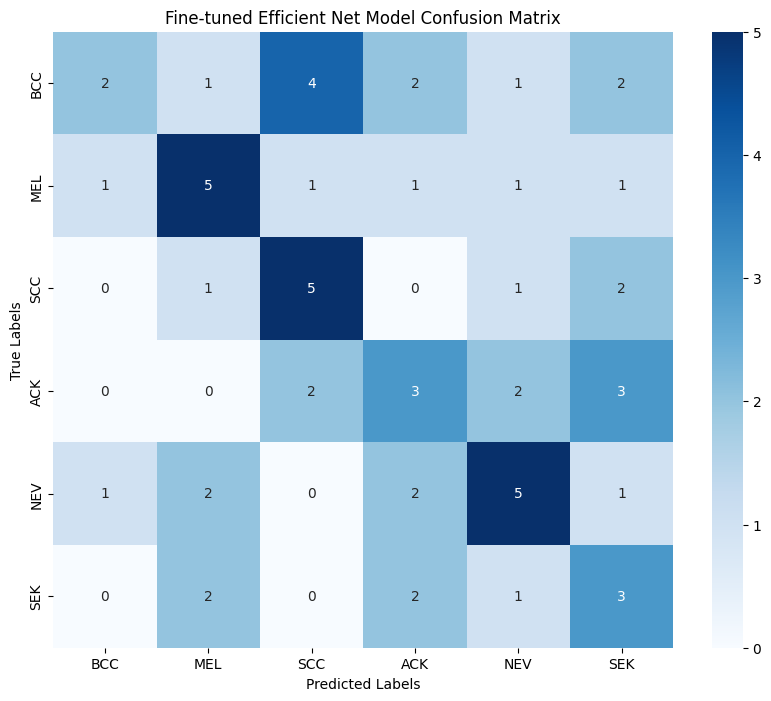

In [60]:
model.load_state_dict(torch.load('best_model.pth'))
evaluate_model(model, test_loader, True)

In [61]:
# save model
torch.save(model.state_dict(), 'efficientnet_skin_cancer_classifier6.pth')

## Classifying between Malignant and Benign
Binary classifier

In [62]:
df = pd.read_csv("../data/metadata.csv")
new_df = df[['img_id', 'diagnostic']]
new_df['img_id'] = "../DATA/images/" + new_df['img_id'].astype(str)

# malignant - 1, benign - 0 (two classes)
mapping = {'BCC':1, 'MEL':1, 'SCC':1 , 'ACK':0, 'NEV':0, 'SEK':0}
new_df['class'] = new_df['diagnostic'].map(mapping)
new_df = new_df.drop(['diagnostic'], axis=1)

train_df, temp = train_test_split(new_df, test_size=0.4, random_state=42)  # 60% train
test_df, val_df = train_test_split(temp, test_size=0.5, random_state=42)  # Split remaining 40% equally

train_df.to_csv("../data/train2.csv", index=False)
test_df.to_csv("../data/test2.csv", index=False)
val_df.to_csv("../data/val2.csv", index=False)

# load data with dataloader
train_dataset = SkinCancerDataset(csv_file='../data/train2.csv', transform=train_transforms)
val_dataset = SkinCancerDataset(csv_file='../data/val2.csv', transform=val_transforms)
test_dataset = SkinCancerDataset(csv_file='../data/test2.csv', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# load EfficientNet and modify the classifier layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(pretrained=True)
num_classes = len(train_dataset.data['class'].unique())
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

C:\Users\surfd\AppData\Local\Temp\ipykernel_24180\786655237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['img_id'] = "../DATA/images/" + new_df['img_id'].astype(str)
C:\Users\surfd\AppData\Local\Temp\ipykernel_24180\786655237.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['class'] = new_df['diagnostic'].map(mapping)
c:\Users\surfd\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0

In [63]:
def evaluate_model_twoclass(model, dloader, ft_check):
    model.eval()
    dpreds, dlabels, dprobs = [], [], []

    with torch.no_grad():
        for images, labels in dloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get the predicted class for each image (for accuracy and F1)
            preds = outputs.argmax(dim=1)
            # Get predicted probabilities for AUC (softmax output)
            probs = F.softmax(outputs, dim=1)[:, 1]

            # Store predictions and true labels
            dpreds.extend(preds.cpu().numpy())
            dlabels.extend(labels.cpu().numpy())
            dprobs.extend(probs.cpu().numpy())

    # Print predictions with their probabilities
    for idx in dpreds:
        label = "Benign" if dpreds == 0 else "Malignant"
        prob = torch.softmax(outputs, dim=1)[0, idx].item()
        print('{:<75} ({:.2f}%)'.format(label, prob*100))

    # Calculate evaluation metrics
    accuracy = accuracy_score(dlabels, dpreds)
    f1 = f1_score(dlabels, dpreds, average='macro')
    auc = roc_auc_score(dlabels, dprobs, average='macro', multi_class='ovr')

    print(f'Accuracy: {accuracy}')
    print(f'F1 Score: {f1}')
    print(f'AUC: {auc}')

    # Step 6: Confusion Matrix
    conf_matrix = confusion_matrix(dlabels, dpreds)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    if(ft_check):
        plt.title("Fine-tuned Efficient Net Model Confusion Matrix")
    else:
        plt.title("Pre-trained Efficient Net Model Confusion Matrix")
    plt.show()

Malignant                                                                   (60.76%)
Malignant                                                                   (60.76%)
Malignant                                                                   (60.76%)
Malignant                                                                   (60.76%)
Malignant                                                                   (60.76%)
Malignant                                                                   (60.76%)
Malignant                                                                   (60.76%)
Malignant                                                                   (60.76%)
Malignant                                                                   (60.76%)
Malignant                                                                   (60.76%)
Malignant                                                                   (60.76%)
Malignant                                                        

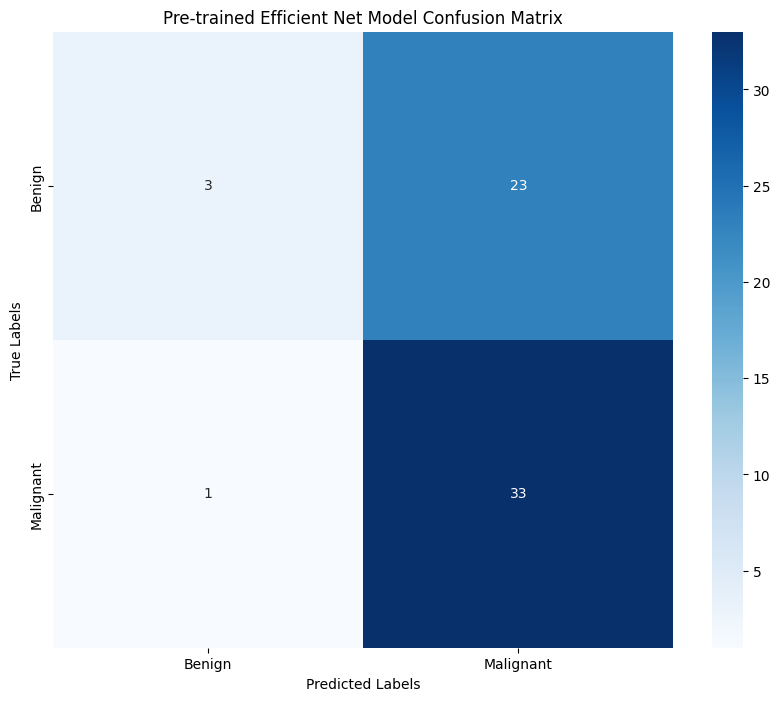

In [64]:
# test base model
evaluate_model_twoclass(model, val_loader, False)

In [65]:
# freeze earlier layers / only fine tune the bottom layer
for param in model.features.parameters():
    param.requires_grad = False

# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [66]:
# train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

Malignant                                                                   (67.86%)
Malignant                                                                   (67.86%)
Malignant                                                                   (67.86%)
Malignant                                                                   (32.14%)
Malignant                                                                   (67.86%)
Malignant                                                                   (67.86%)
Malignant                                                                   (67.86%)
Malignant                                                                   (67.86%)
Malignant                                                                   (67.86%)
Malignant                                                                   (67.86%)
Malignant                                                                   (67.86%)
Malignant                                                        

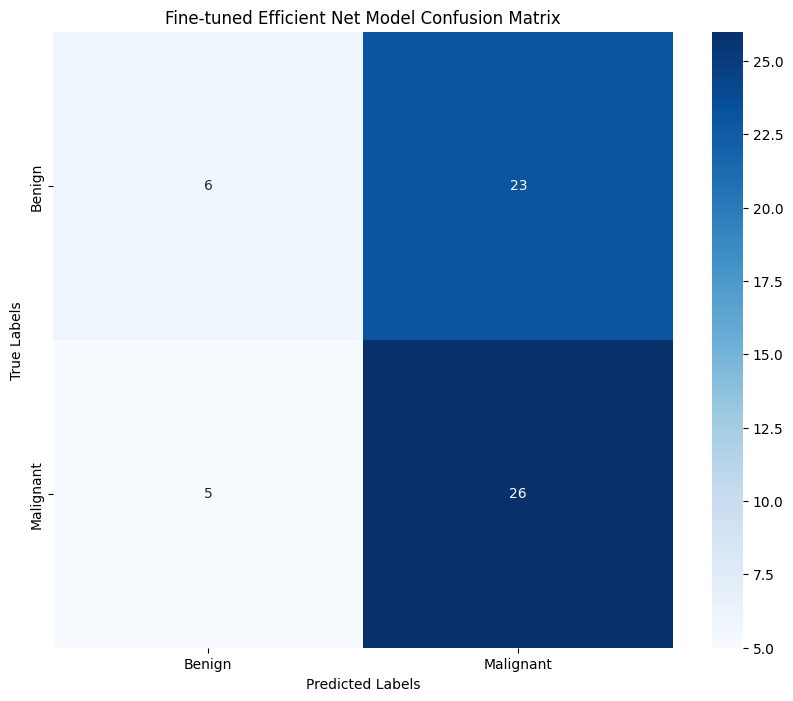

In [67]:
# evaluate model
model.load_state_dict(torch.load('best_model.pth'))
evaluate_model_twoclass(model, test_loader, True)

# save model
torch.save(model.state_dict(), 'efficientnet_skin_cancer_classifier2.pth')